In [5]:
%matplotlib inline
import theano
import theano.tensor as T
import numpy as np
import matplotlib.pyplot as plt

## theano basic

In [9]:
foo = T.scalar('foo')
bar = foo**2
print(type(bar))
print(bar.type)

<class 'theano.tensor.var.TensorVariable'>
TensorType(float64, scalar)


In [11]:
f = theano.function([foo],bar)
print(f(3))
print(bar.eval({foo:3}))

9.0
9.0


In [16]:
A = T.matrix('A')
x = T.vector('x')
b = T.vector('b')
y = T.dot(A,x) + b
z = T.sum(A**2)

b_default = np.array([0,0],dtype=theano.config.floatX)
linear_mix = theano.function([A, x, theano.Param(b, default=b_default)],[y,z])
print(linear_mix(np.array([[1,2,3],
                          [4,5,6]], dtype=theano.config.floatX),
                np.array([1,2,3],dtype=theano.config.floatX),
                np.array([4,5],dtype=theano.config.floatX)))
print(linear_mix(np.array([[1,2,3],
                        [4,5,6]], dtype = theano.config.floatX),
                        np.array([1,2,3], dtype = theano.config.floatX)))


[array([ 18.,  37.]), array(91.0)]
[array([ 14.,  32.]), array(91.0)]


In [21]:
shared_var = theano.shared(np.array([[1,2],[3,4]],dtype=theano.config.floatX))
print(shared_var)
print(shared_var.get_value())

<TensorType(float64, matrix)>
[[ 1.  2.]
 [ 3.  4.]]


In [22]:
bar_grad = T.grad(bar,foo)
bar_grad.eval({foo:10})

array(20.0)

In [25]:
y_J = theano.gradient.jacobian(y,x)
linear_mix_J = theano.function([A, x,b],y_J)
print(linear_mix_J(np.array([[9,8,7],[4,5,6]],dtype = theano.config.floatX),
                  np.array([1,2,3],dtype=theano.config.floatX),
                  np.array([4,5],dtype = theano.config.floatX)))

[[ 9.  8.  7.]
 [ 4.  5.  6.]]


In [26]:
print(theano.config.device)

cpu


## MLP

In [54]:
class Layer(object):
    def __init__(self, W_init, b_init, activation):
        n_output,n_input = W_init.shape
        assert b_init.shape == (n_output,)
        self.W = theano.shared(value=W_init.astype(theano.config.floatX),
                            name='W',borrow=True)
        self.b = theano.shared(value=b_init.reshape(n_output,1).astype(theano.config.floatX),
                              name='b',borrow=True,broadcastable=(False,True))
        self.activation = activation
        self.params = [self.W,self.b]
    def output(self,x):
        lin_output = T.dot(self.W,x)+self.b
        return(lin_output if self.activation is None else self.activation(lin_output))
    
class MLP(object):
    def __init__(self, W_init,b_init,activations):
        assert len(W_init) == len(b_init) == len(activations)
        self.layers = []
        for W,b,activation in zip(W_init, b_init, activations):
            self.layers.append(Layer(W,b,activation))
        self.params = []
        for layer in self.layers:
            self.params += layer.params
    def output(self,x):
        for layer in self.layers:
            x = layer.output(x)
        return x
    
    def squared_error(self,x,y):
        return T.sum((self.output(x)-y)**2)
    
def gradient_updates_momentum(cost,params,learning_rate,momentum):
    assert momentum < 1 and momentum >= 0
    updates = []
    for param in params:
        param_update = theano.shared(param.get_value()*0.,broadcastable=param.broadcastable)
        updates.append((param,param - learning_rate*param_update))
        updates.append((param_update,momentum*param_update +(1.-momentum)*T.grad(cost,param)))
    return updates

                                     

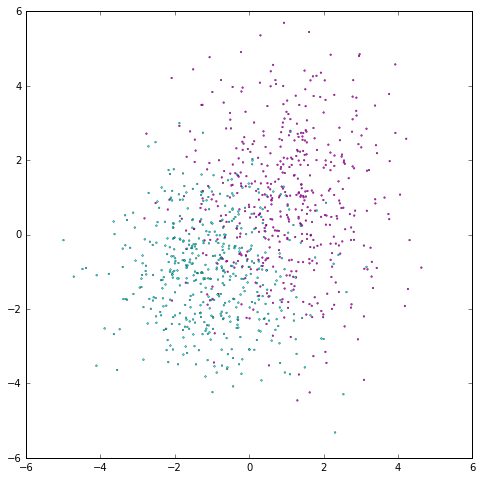

In [42]:
np.random.seed(0)
N = 1000
y = np.random.random_integers(0,1,N)
means = np.array([[-1,1],[-1,1]])
covariances = np.random.random_sample((2,2))+1
X = np.vstack([np.random.randn(N)*covariances[0,y]+means[0,y],
              np.random.randn(N)*covariances[1,y]+means[1,y]]).astype(theano.config.floatX)
y = y.astype(theano.config.floatX)

plt.figure(figsize=(8,8))
plt.scatter(X[0,:],X[1,:],c=y,lw=.3,s=3,cmap=plt.cm.cool)
plt.axis([-6,6,-6,6])
plt.show()

In [55]:
layer_sizes = [X.shape[0],X.shape[0]*2,1]
W_init = []
b_init = []
activations = []
for n_input, n_output in zip(layer_sizes[:-1],layer_sizes[1:]):
    W_init.append(np.random.randn(n_output,n_input))
    b_init.append(np.ones(n_output))
    activations.append(T.nnet.sigmoid)
mlp = MLP(W_init,b_init,activations)

mlp_input = T.matrix('mlp_input')
mlp_target = T.vector('mlp_target')
learning_rate = 0.01
momentum = 0.9
cost = mlp.squared_error(mlp_input,mlp_target)
train = theano.function([mlp_input,mlp_target],cost,
            updates = gradient_updates_momentum(cost,mlp.params,learning_rate,momentum))
mlp_output =theano.function([mlp_input],mlp.output(mlp_input))


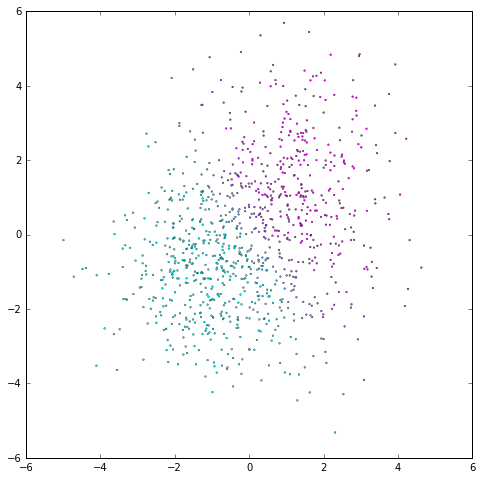

In [58]:
max_iteration = 20
iteration = 0
while iteration<max_iteration:
    current_cost = train(X,y)
    current_output = mlp_output(X)
    accuracy = np.mean((current_output<.5)==y)
    iteration += 1
plt.figure(figsize=(8,8))
plt.scatter(X[0,:],X[1,:],c=current_output,lw=.3,s=3,cmap=plt.cm.cool,vmin=0,vmax=1)
plt.axis([-6,6,-6,6])
plt.show()